In [2]:
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# Reading the file
df = pd.read_csv('C:/Users/OWNER/Downloads/heart.csv')

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
for col in df.columns:
    print(f'{col} has {df[col].nunique()} unique values.')

Age has 50 unique values.
Sex has 2 unique values.
ChestPainType has 4 unique values.
RestingBP has 67 unique values.
Cholesterol has 222 unique values.
FastingBS has 2 unique values.
RestingECG has 3 unique values.
MaxHR has 119 unique values.
ExerciseAngina has 2 unique values.
Oldpeak has 53 unique values.
ST_Slope has 3 unique values.
HeartDisease has 2 unique values.


In [6]:
df.duplicated().sum()

0

In [7]:
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [8]:
for col in cat_cols:
    print(f'The unique values in {col} are: {df[col].unique()}')

The unique values in Sex are: ['M' 'F']
The unique values in ChestPainType are: ['ATA' 'NAP' 'ASY' 'TA']
The unique values in FastingBS are: [0 1]
The unique values in RestingECG are: ['Normal' 'ST' 'LVH']
The unique values in ExerciseAngina are: ['N' 'Y']
The unique values in ST_Slope are: ['Up' 'Flat' 'Down']


In [9]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no null values. Hence, we can do the data analysis.

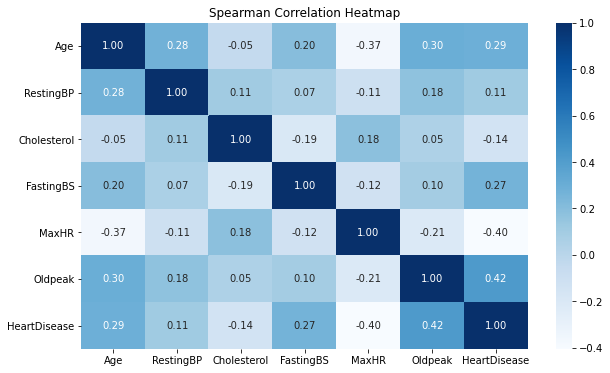

In [10]:
corr = df.corr(method = 'spearman')
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Spearman Correlation Heatmap')
plt.show()

<Figure size 1080x576 with 0 Axes>

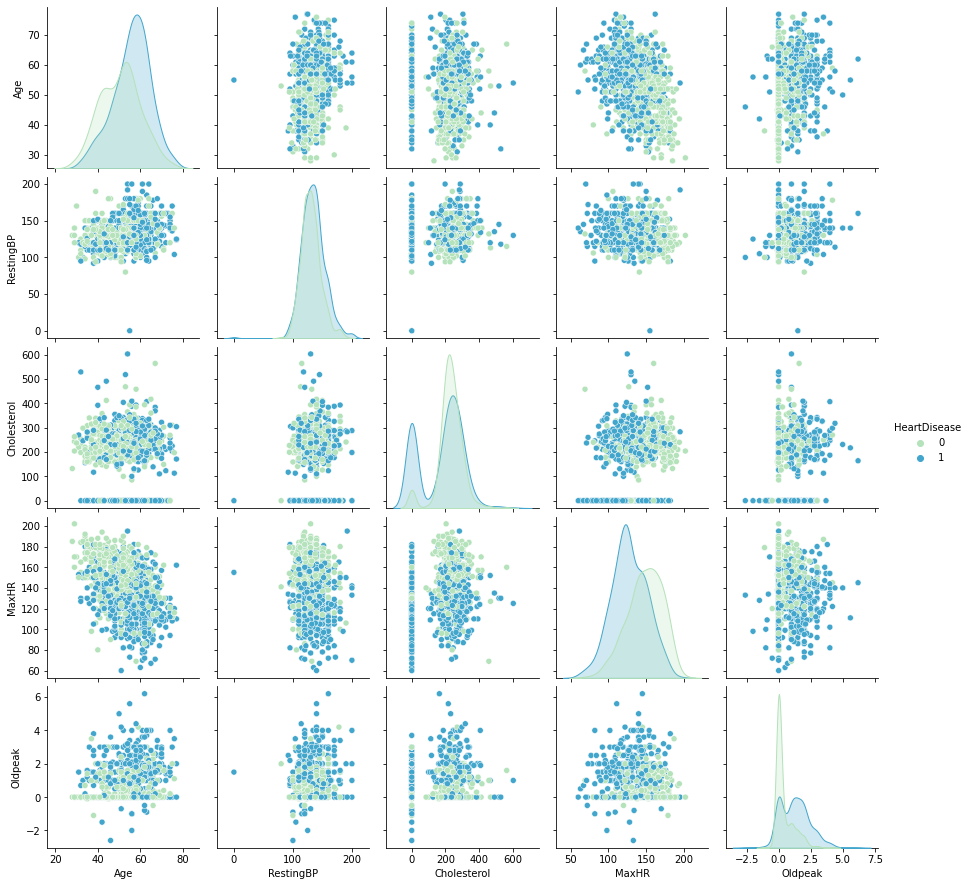

In [11]:
pairplot_cols = num_cols
pairplot_cols.append('HeartDisease')
figure = plt.figure(figsize=(15,8))
sns.pairplot(df[pairplot_cols], hue='HeartDisease', palette='GnBu')
plt.show()

Something that I noticed in the cholesterol column is that there are a lot of entries with value as 0. Let's see how many such entries are there.

In [13]:
df.loc[df['Cholesterol'] == 0, 'Cholesterol'].count()

172

In [14]:
df.loc[(df['Cholesterol'] == 0) & (df['HeartDisease'] == 1), 'Cholesterol'].count()


152

There are 172 values with cholesterol value 0 and I think this has been done to fill the missing data. Out of 172 values, 152 have heart disease. Let's just remove this column because these 172 values are basically missing values imputed with 0.

In [15]:
df.drop('Cholesterol', axis=1, inplace=True)
num_cols.remove('Cholesterol')

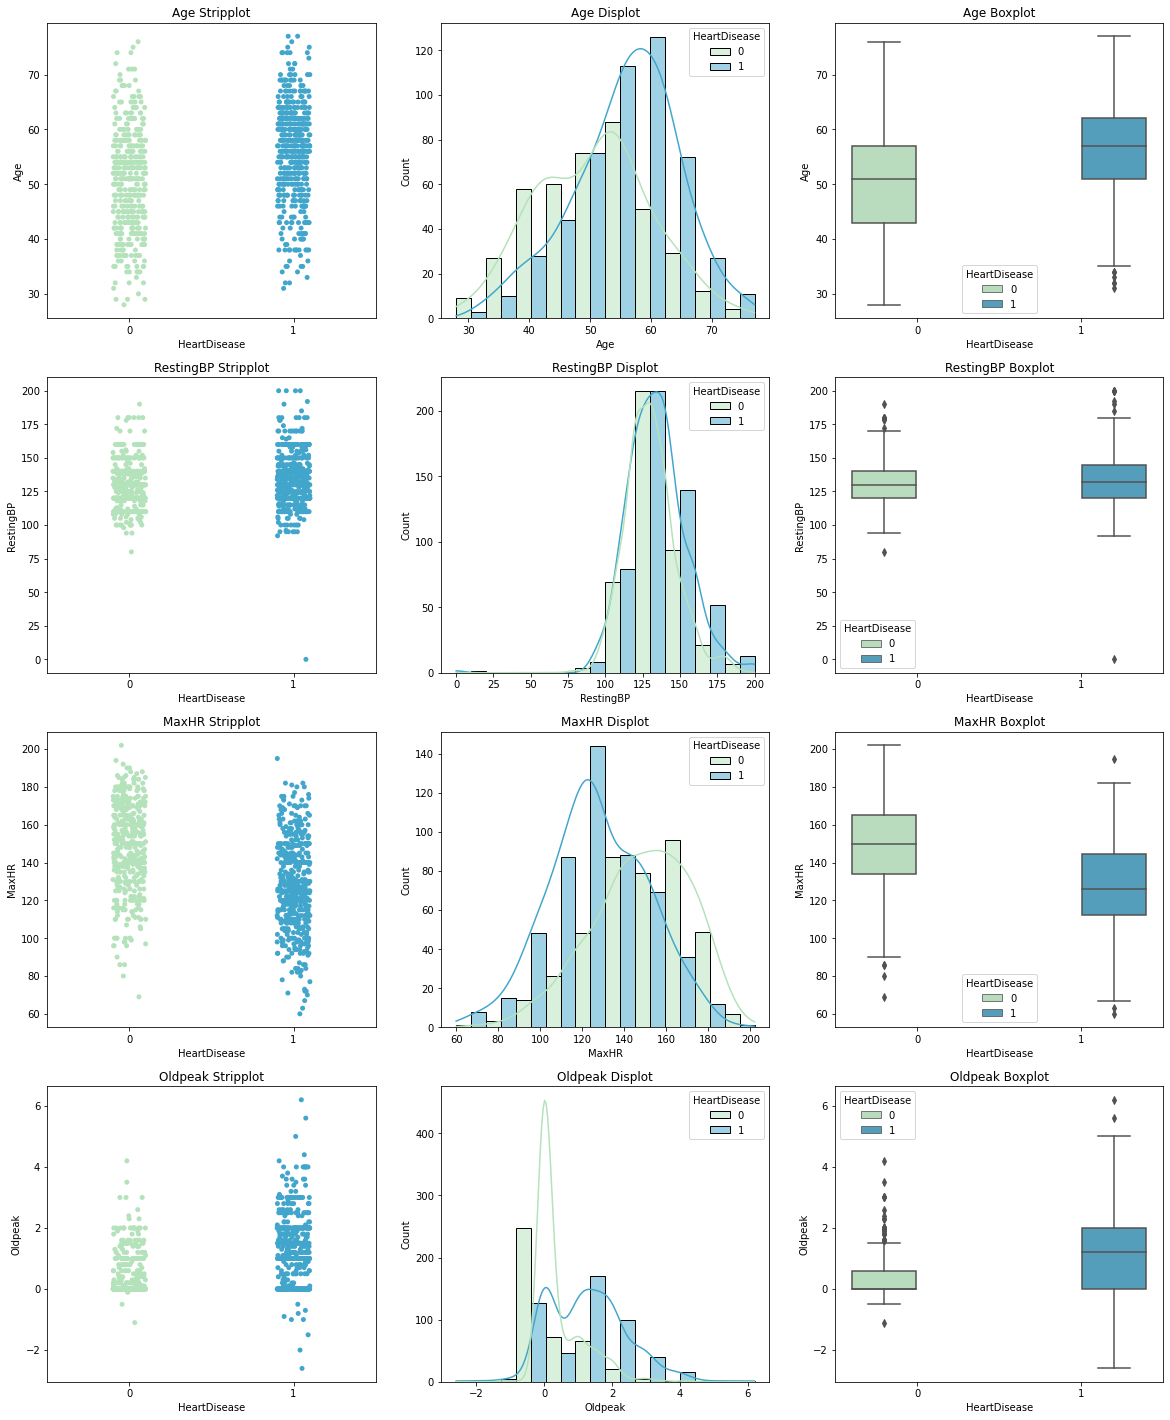

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(20,25))
for i, col in zip(range(4), num_cols):
    sns.stripplot(ax=axes[i][0], x='HeartDisease', y=col, data=df, palette='GnBu', jitter=True)
    axes[i][0].set_title(f'{col} Stripplot')
    sns.histplot(ax=axes[i][1], x=col, data=df, kde=True, bins=10, palette='GnBu', hue='HeartDisease', multiple='dodge')
    axes[i][1].set_title(f'{col} Displot')
    sns.boxplot(ax=axes[i][2], x='HeartDisease', y=col, data=df, palette='GnBu', hue='HeartDisease')
    axes[i][2].set_title(f'{col} Boxplot')

There are some outliers in the numerical columns. Let's replace them with the threshold values using interquantile range.

In [17]:
def outlier_limits(df, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_limits(df, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_limits(df, variable, q1 = q1, q3 = q3)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit
    
for variable in df[num_cols].columns:
    replace_with_limits(df, variable)

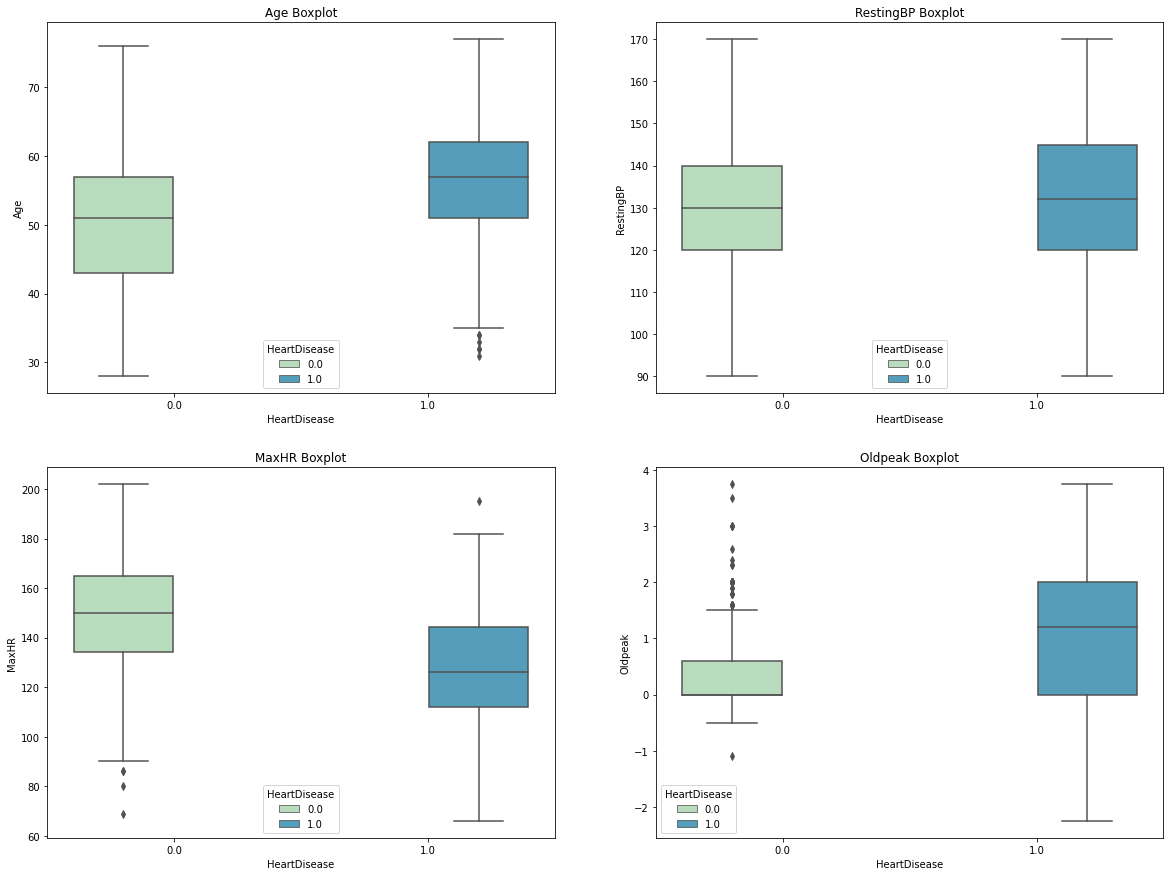

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
for i, col in zip(range(4), num_cols):
    sns.boxplot(ax=axes[i//2][i%2], x='HeartDisease', y=col, data=df, palette='GnBu', hue='HeartDisease')
    axes[i//2][i%2].set_title(f'{col} Boxplot')

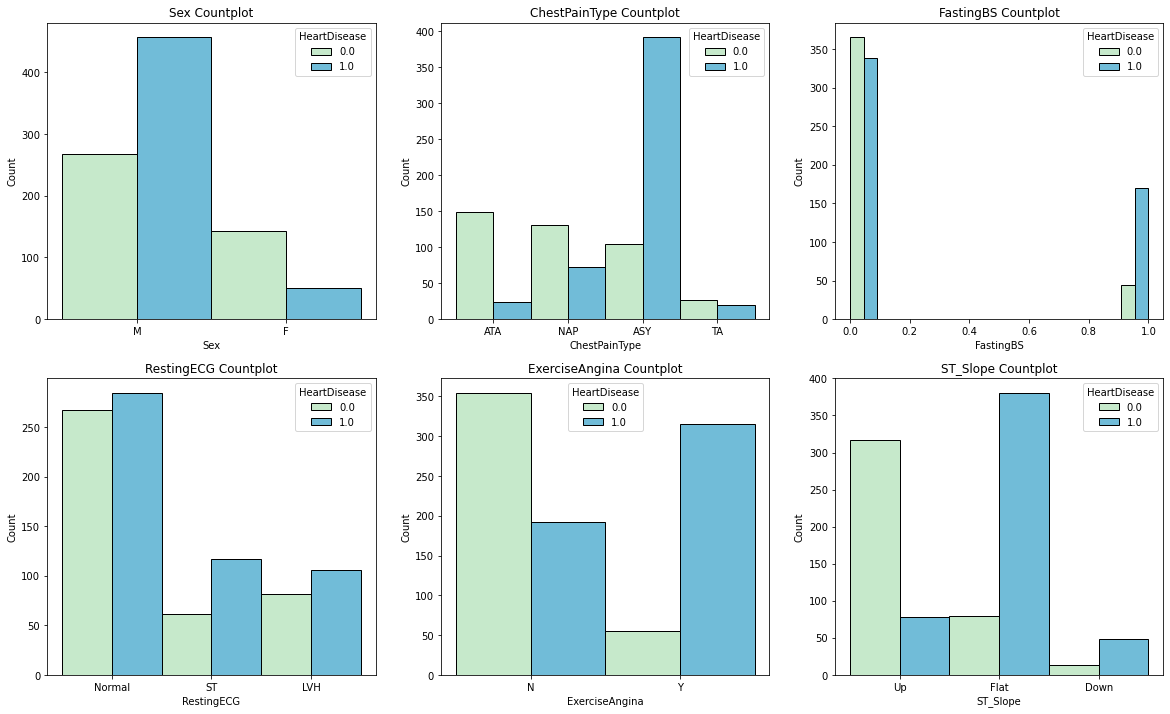

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(20,12))
for i, col in zip(range(6), cat_cols):
    sns.histplot(ax=axes[i//3][i%3], x=col, data=df, palette='GnBu', hue='HeartDisease', multiple='dodge', bins='auto')
    axes[i//3][i%3].set_title(f'{col} Countplot')

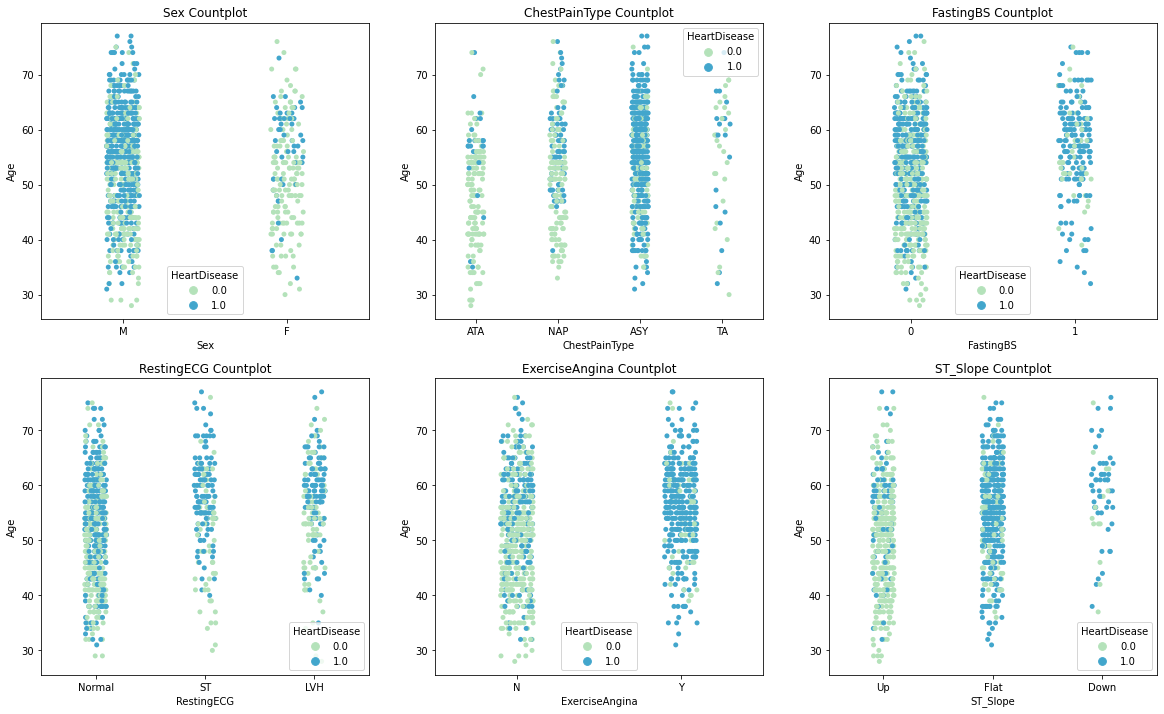

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(20,12))
for i, col in zip(range(6), cat_cols):
    sns.stripplot(ax=axes[i//3][i%3], x=col, y='Age', data=df, palette='GnBu', hue='HeartDisease', jitter=True)
    axes[i//3][i%3].set_title(f'{col} Countplot')

In [21]:
eda_num_cols = ['RestingBP', 'MaxHR', 'Oldpeak']

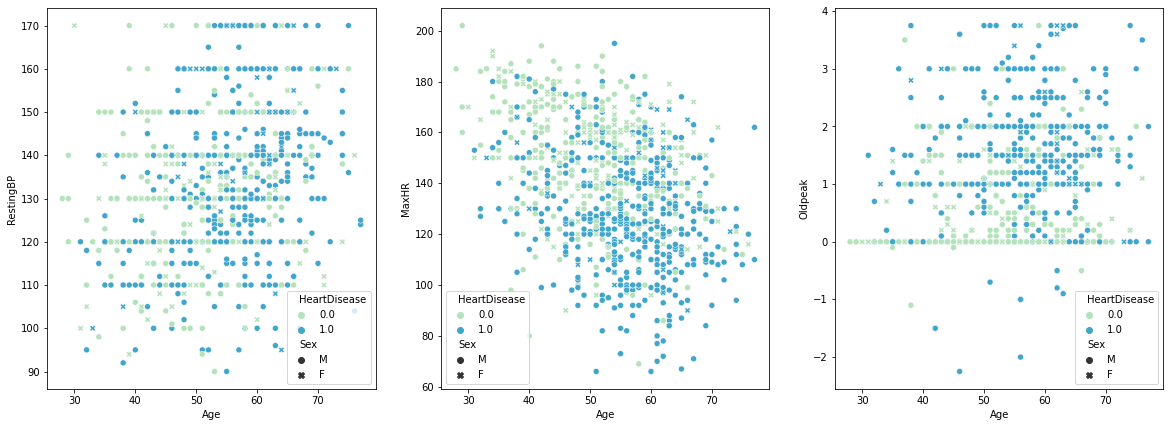

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
for i, col in zip(range(3), eda_num_cols):
    sns.scatterplot(ax=axes[i], x='Age', y=col, hue="HeartDisease", style="Sex", data=df.iloc[0:889,:], palette="GnBu")

All features seem to be useful ahead as you can see that some categorical variables have certain values that have a lot of people with heart disease. The features aren't correlated which is good. With this, we are done with our EDA.

# Scaling and Encoding

In [23]:
num_cols.remove('HeartDisease')

In [24]:
print(cat_cols)
print(num_cols)

['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
['Age', 'RestingBP', 'MaxHR', 'Oldpeak']


We want to apply different types of encoding techniques for different variables. Let's use column transformer to achieve this.

In [25]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:10]
y = df['HeartDisease']
X.head()

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40.0,M,ATA,140.0,0,Normal,172.0,N,0.0,Up
1,49.0,F,NAP,160.0,0,Normal,156.0,N,1.0,Flat
2,37.0,M,ATA,130.0,0,ST,98.0,N,0.0,Up
3,48.0,F,ASY,138.0,0,Normal,108.0,Y,1.5,Flat
4,54.0,M,NAP,150.0,0,Normal,122.0,N,0.0,Up


In [26]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers = [
        ('onehotcat', OneHotEncoder(), ['ChestPainType', 'ST_Slope', 'RestingECG', 'Sex', 'ExerciseAngina']),
        ('num', MinMaxScaler(), num_cols),
    ],
    remainder = 'passthrough'
)

In [27]:
features = ['x0_ASY', 'x0_ATA', 'x0_NAP', 'x0_TA', 'x1_Down', 'x1_Flat', 'x1_Up', 'x2_LVH', 'x2_Normal', 'x2_ST', 'x3_F', 'x3_M', 'x4_N', 'x4_Y', 'Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'FastingBS']

When using column transformer, the items in array will be in the order in which they get encoded. So the OHE variables come first, followed by scaled variables and then the variables that didn't require preprocessing.

In [28]:
X = pd.DataFrame(preprocessor.fit_transform(X), columns=features)
X.head()

,x0_ASY,x0_ATA,x0_NAP,x0_TA,x1_Down,x1_Flat,x1_Up,x2_LVH,x2_Normal,x2_ST,x3_F,x3_M,x4_N,x4_Y,Age,RestingBP,MaxHR,Oldpeak,FastingBS
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.244898,0.625,0.779412,0.375000,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.428571,0.875,0.661765,0.541667,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.183673,0.500,0.235294,0.375000,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.408163,0.600,0.308824,0.625000,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.530612,0.750,0.411765,0.375000,0.0


You can use the code below for VIF to drop columns that show multicollinearity. I will be using VarianceThreshold later on as a selector in the pipeline to remove constant and quasi-constant features.

In [ ]:
# import statsmodels.api as sm
# def calculate_vif(data):
#     vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
#     x_var_names = X.columns
#     for i in range(0, x_var_names.shape[0]):
#         y = X[x_var_names[i]]
#         x = X[x_var_names.drop([x_var_names[i]])]
#         r_squared = sm.OLS(y,x).fit().rsquared
#         vif = round(1/(1-r_squared),2)
#         vif_df.loc[i] = [x_var_names[i], vif]
#     return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

# calculate_vif(X)

# Machine Learning


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold

In [31]:
def fit(clf, params, cv=10, preprocessor=preprocessor, X_train=X_train, y_train=y_train):
    selector = VarianceThreshold()
    params['selector__threshold'] = [0, 0.1, 0.2]
    pipeline = Pipeline([('selector', selector),
                       ('clf', clf)])
    grid = GridSearchCV(pipeline, params, cv=KFold(n_splits=cv), n_jobs=1, verbose=1, return_train_score=True, scoring='accuracy') #verbose and n_jobs help us see the computation time and score of a cv. Higher the value of verbose, more the information printed out.
    grid.fit(X_train, y_train)
    return grid

def make_predictions(model, X_test=X_test):
    return model.predict(X_test)

def best_scores(model):
    # print(f'The mean cross validation test score is: {model.cv_results_.mean_test_score}') #for some reason this wasn't working for me even though the attribute exists so lets just leave it.
    print(f'The best parameters are: {model.best_params_}')
    print(f'The best score that we got is: {model.best_score_}')
    return None

def plot_confusion_matrix(y_pred):
    print('00: True Negatives\n01: False Positives\n10: False Negatives\n11: True Positives\n')
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap='GnBu', alpha=0.75)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large') 
    plt.xlabel('Predictions', fontsize=14)
    plt.ylabel('Actuals', fontsize=14)
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()
    return None

def check_scores(y_pred):
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    print('ROC-AUC Score: %.3f' % roc_auc_score(y_test, y_pred))
    return None

# Logistic Regression

In [32]:
lr_params = {'clf__C':[0.001,.009,0.01,.09,1,5,10,25], 'clf__penalty':['l1', 'l2']} #lasso and ridge regression
lr_clf = LogisticRegression(solver='saga', max_iter=5000)
lr_model = fit(lr_clf, lr_params)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [33]:
best_scores(lr_model)

The best parameters are: {'clf__C': 0.09, 'clf__penalty': 'l2', 'selector__threshold': 0.1}
The best score that we got is: 0.8609218807848944


In [34]:
lr_y_pred = make_predictions(lr_model)
check_scores(lr_y_pred)

Precision: 0.880
Recall: 0.931
Accuracy: 0.891
F1 Score: 0.905
ROC-AUC Score: 0.886


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



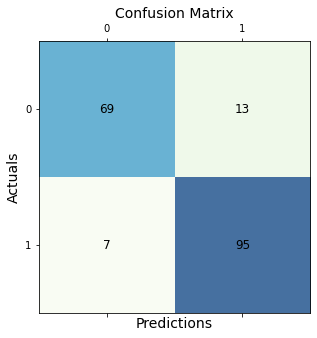

In [35]:
plot_confusion_matrix(lr_y_pred)

In [36]:
lr_model.best_estimator_['selector'].get_support()
#Using this I am checking which features were dropped and you can see that none of them were dropped. Lets add more threshold values.

array([ True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True])

# Gaussian Naive Bayes

In [37]:
gnb_params = {'clf__priors': [None], 'clf__var_smoothing': np.logspace(0,-9, num=100)}
gnb_clf = GaussianNB()
gnb_model = fit(gnb_clf, gnb_params)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


In [38]:
best_scores(gnb_model)

The best parameters are: {'clf__priors': None, 'clf__var_smoothing': 0.43287612810830584, 'selector__threshold': 0}
The best score that we got is: 0.8567937800814512


In [39]:
gnb_y_pred = make_predictions(gnb_model)
check_scores(gnb_y_pred)

Precision: 0.897
Recall: 0.853
Accuracy: 0.864
F1 Score: 0.874
ROC-AUC Score: 0.865


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



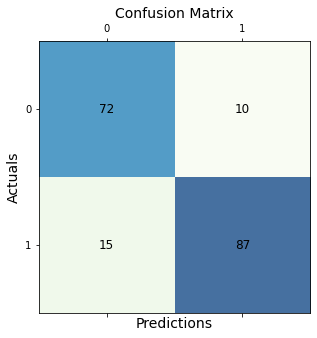

In [40]:
plot_confusion_matrix(gnb_y_pred)

# K-NNs

In [41]:
knns_params = {'clf__n_neighbors': list(range(1, 31)), 'clf__weights': ['uniform', 'distance'], 
               'clf__metric': ['euclidean', 'manhattan']}
knns_clf = KNeighborsClassifier()
knns_model = fit(knns_clf, knns_params)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


In [42]:
best_scores(knns_model)

The best parameters are: {'clf__metric': 'euclidean', 'clf__n_neighbors': 25, 'clf__weights': 'uniform', 'selector__threshold': 0}
The best score that we got is: 0.8581821547574972


In [43]:
knns_y_pred = make_predictions(knns_model)
check_scores(knns_y_pred)

Precision: 0.883
Recall: 0.892
Accuracy: 0.875
F1 Score: 0.888
ROC-AUC Score: 0.873


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



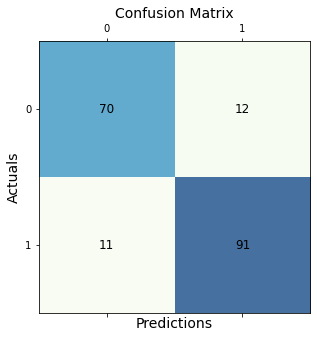

In [44]:
plot_confusion_matrix(knns_y_pred)

# SVM

In [45]:
svm_params = {'clf__C':[1,10,100,1000], 'clf__gamma':[1,0.1,0.001,0.0001], 'clf__kernel':['linear','rbf']}
svm_clf = SVC()
svm_model = fit(svm_clf, svm_params)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


In [46]:
best_scores(svm_model)

The best parameters are: {'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'linear', 'selector__threshold': 0}
The best score that we got is: 0.8581821547574972


In [47]:
svm_y_pred = make_predictions(svm_model)
check_scores(svm_y_pred)

Precision: 0.865
Recall: 0.882
Accuracy: 0.859
F1 Score: 0.874
ROC-AUC Score: 0.856


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



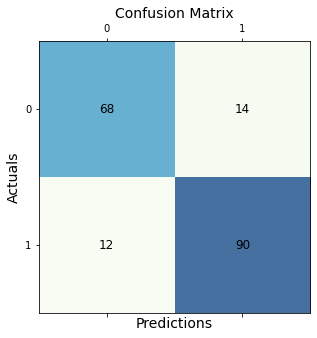

In [48]:
plot_confusion_matrix(svm_y_pred)

# Decision Trees

In [50]:
dt_params = {'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': range(1,10), 
             'clf__min_samples_leaf': range(1,5)}
dt_clf = DecisionTreeClassifier()
dt_model = fit(dt_clf, dt_params)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


In [52]:
best_scores(dt_model)

The best parameters are: {'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__min_samples_leaf': 1, 'selector__threshold': 0.1}
The best score that we got is: 0.8568493150684932


In [53]:
dt_y_pred = make_predictions(dt_model)
check_scores(dt_y_pred)

Precision: 0.833
Recall: 0.931
Accuracy: 0.859
F1 Score: 0.880
ROC-AUC Score: 0.850


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



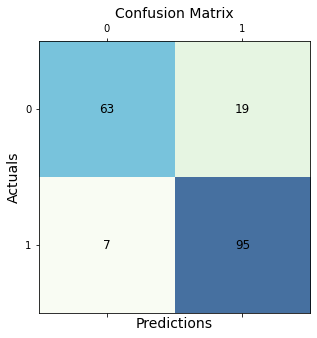

In [54]:
plot_confusion_matrix(dt_y_pred)

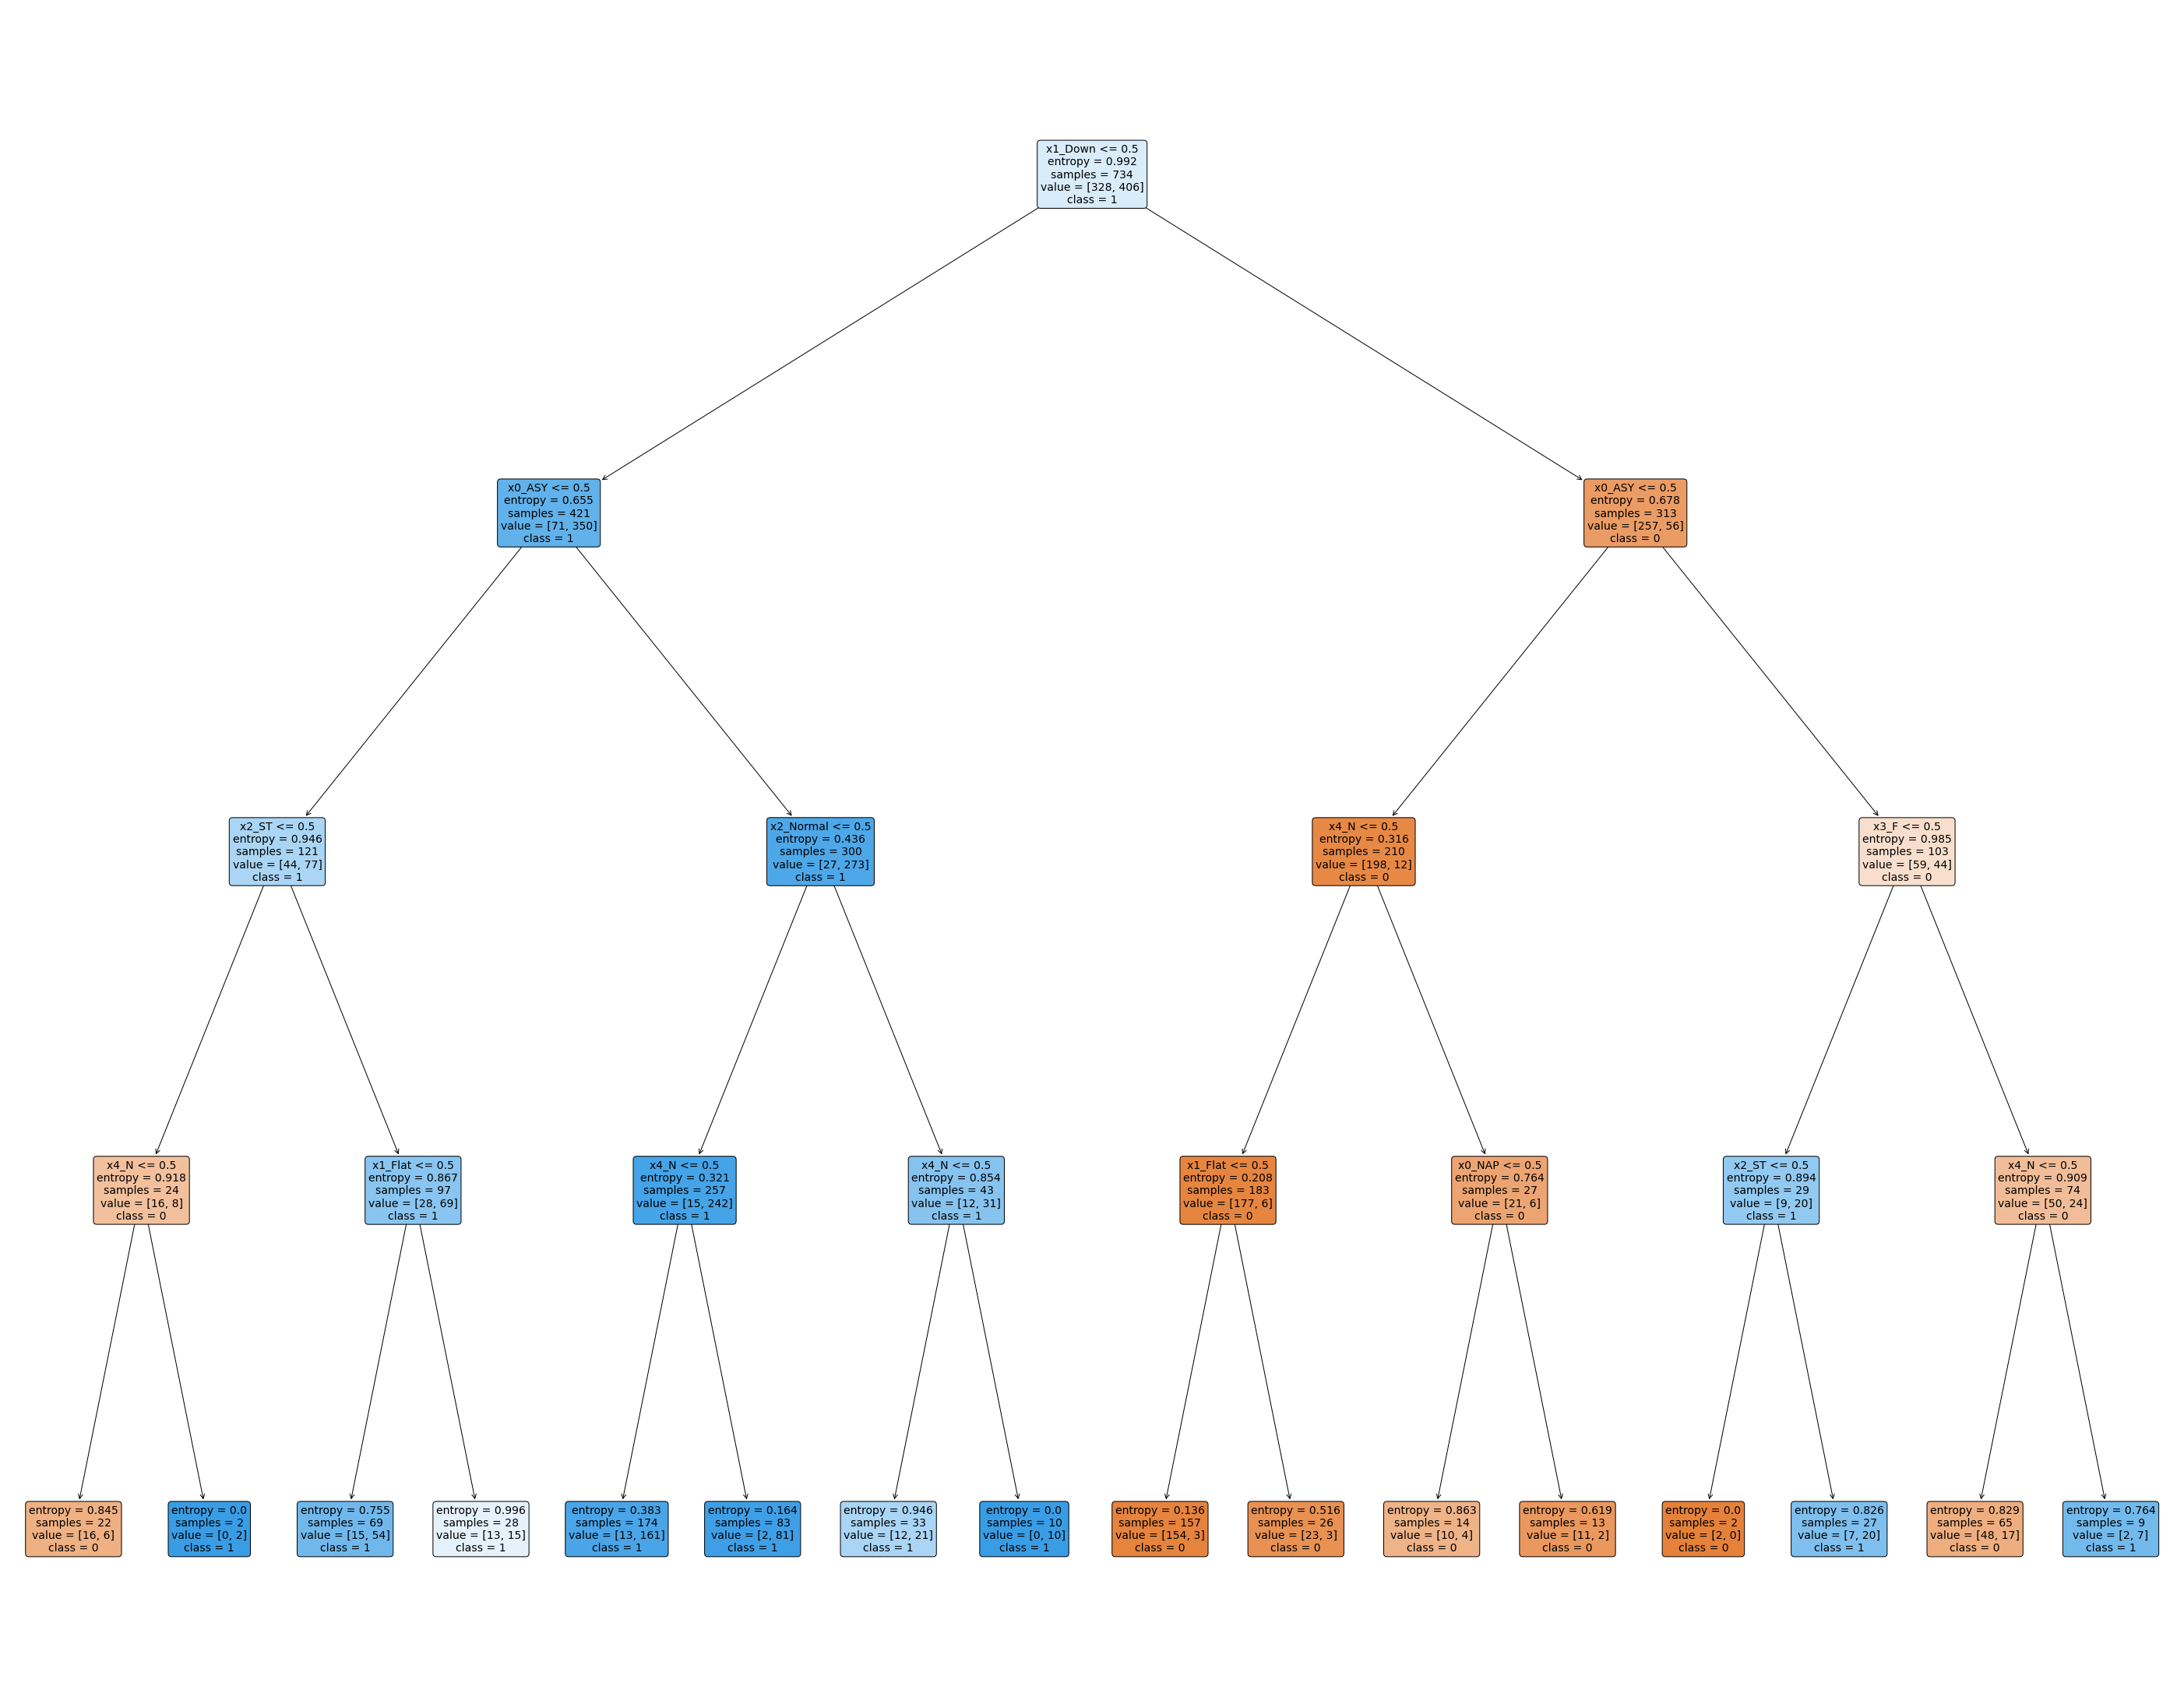

In [55]:
fig = plt.figure(figsize=(50,40))
tree.plot_tree(dt_model.best_estimator_['clf'], feature_names=features,  class_names=['0','1'], filled=True, fontsize=14, rounded=True)
plt.show()

# Random Forest

In [56]:
rf_params = {'clf__criterion' :['gini', 'entropy'], 'clf__min_samples_leaf': [3, 4, 5], 
             'clf__min_samples_split': [8, 10, 12], 'clf__n_estimators': [100,250,500,600,700,800,900,1000]}
rf_clf = RandomForestClassifier()
rf_model = fit(rf_clf, rf_params, cv=5)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [57]:
best_scores(rf_model)

The best parameters are: {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 8, 'clf__n_estimators': 500, 'selector__threshold': 0}
The best score that we got is: 0.8637312459230267


In [58]:
rf_y_pred = make_predictions(rf_model)
check_scores(rf_y_pred)

Precision: 0.876
Recall: 0.902
Accuracy: 0.875
F1 Score: 0.889
ROC-AUC Score: 0.872


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



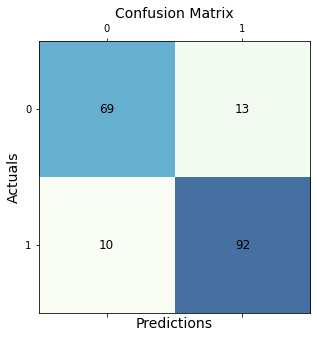

In [59]:
plot_confusion_matrix(rf_y_pred)